In [ ]:
fmow_dataset_path = "/Code/Datasets/fMoW/train"

In [1]:
from tqdm.notebook import tqdm
import sys
import wget
import requests
import os
from PIL import Image, ImageDraw
from IPython.display import display
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../../mae')
import models_mae
from models_mae import MaskedAutoencoderViT
from functools import partial
from sklearn.metrics import accuracy_score, recall_score, precision_score
%matplotlib inline




In [2]:
from glob import glob
import os
import PIL.Image
import math
from torchvision.transforms.functional import pil_to_tensor


PIL.Image.MAX_IMAGE_PIXELS = 1909056320
labels = ["airport", "golf_course", "shipyard", "stadium", "wind_farm"]

def load_wilds(path, sample_per_label = 450, training_percent = 0.8):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in tqdm(labels):
        label_dict[label] = []
        for i in tqdm(range(sample_per_label)):
            if not os.path.isdir(f'{path}/{label}/{label}_{i}'):
                continue
                                 
            j = 0
            while True:
                file_path = f'{path}/{label}/{label}_{i}/{label}_{i}_{j}_msrgb.jpg'
                
                if os.path.isfile(file_path) == True:
                    break
                else:
                    j = j + 1
                
            label_dict[label].append(PIL.Image.open(file_path).resize(size=(224, 224)))

    train_ds = []
    eval_ds = []

    for label in labels:
        train_count = math.floor(len(label_dict[label]) * training_percent)
        test_count = len(label_dict[label]) - train_count

        for i in range(train_count):
            if i < len(label_dict[label]):
                train_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} train samples for {label}")
                break

        for i in range(train_count, train_count + test_count):
            if i < len(label_dict[label]):
                eval_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} eval samples for {label}")
                break

    return pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_df, eval_df = load_wilds(fmow_dataset_path)
display(train_df)
display(eval_df)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
...,...,...,...
1515,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
1516,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
1517,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
1518,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4


,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
...,...,...,...
378,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
379,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
380,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
381,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4


In [3]:
class fMoWDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df

        self.y = df.iloc[:, 2]

        df = df.apply(lambda row: pil_to_tensor(row["image"]), axis=1)
        self.x = torch.stack(df.tolist(), dim=0)
        
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

        self.x /= 255.0
        self.x = F.interpolate(self.x, size=(224, 224), mode='bilinear', antialias=True)
        print(self.y.shape)
        print(self.x.shape)
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

eval_ds = fMoWDataset(eval_df)
train_ds = fMoWDataset(train_df)

/tmp/ipykernel_4142/2734982124.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([383])
torch.Size([383, 3, 224, 224])
torch.Size([1520])
torch.Size([1520, 3, 224, 224])


array([[<Axes: title={'center': 'y'}>]], dtype=object)

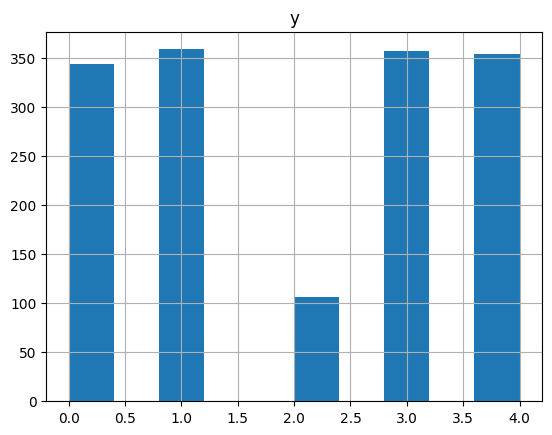

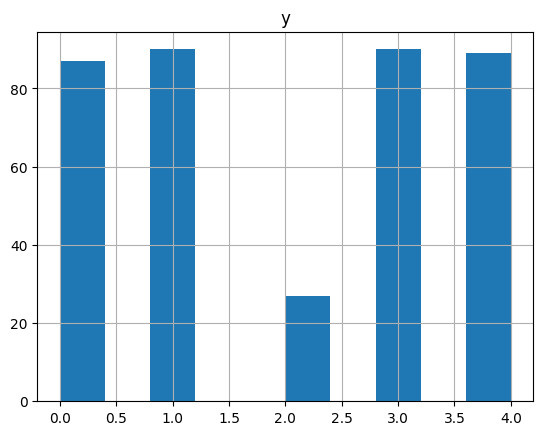

In [4]:
train_df.hist(column = 'y')
eval_df.hist(column = 'y')

In [5]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

/tmp/ipykernel_4142/2734982124.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5, 3, 224, 224])
    airport      golf_course      shipyard      stadium      wind_farm


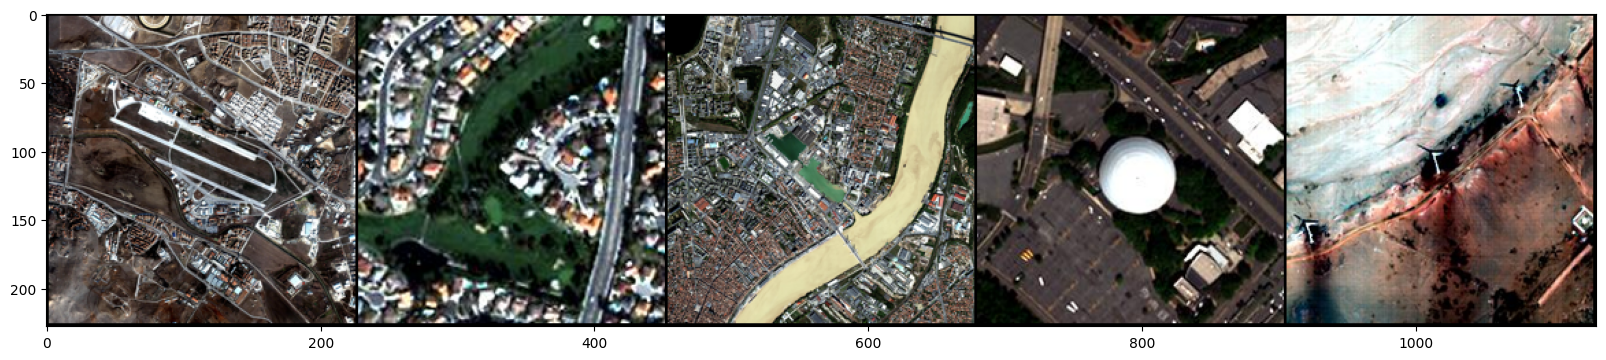

In [6]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = fMoWDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [7]:
# Defining the network architecture

class fMoWModel(nn.Module):
    
    def __init__(self):       
        super().__init__()
        chkpt_dir = 'mae_visualize_vit_large.pth'
        model_mae = self.prepare_model(chkpt_dir)
        print('Model loaded.')
        
        self.backbone_model = model_mae      
        self.backbone_model.cuda()

        self.fc1 = nn.Linear(in_features=1024, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=len(labels))

    def forward(self, X):

        X = self.forward_ecoder(X, self.backbone_model)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return F.log_softmax(input=self.fc3(X), dim=1)  
    
    def prepare_model(self, chkpt_dir):
        # build model
        model = MaskedAutoencoderViT(
            patch_size=16, img_size=224, embed_dim=1024, depth=24, num_heads=16,
            decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
            mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        
        # load model
        checkpoint = torch.load(chkpt_dir, map_location='cuda')
        msg = model.load_state_dict(checkpoint['model'], strict=False)
        print(msg)
        for p in model.parameters():
            p.requires_grad = False 

        print(type(model))
        return model


    def forward_ecoder(self, x, model):
        # run MAE
        emb, mask, id = model.forward_encoder(x.float(), mask_ratio=0.75)
        return emb[:, 0, :]

In [8]:
# Training the model
epochs = 20

writer = SummaryWriter('fMoWLog')

model = fMoWModel()
model = model.cuda()

start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracy_graph = []
precision_graph = []
recall_graph = [] 

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0


    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%28 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    writer.add_scalar("Loss/train", loss, i)     
    train_losses.append(loss.cpu().detach().numpy())

    # Test model per epoch
    model.eval()
    y_true_label = []
    predictions = []
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            y_true_label.extend(y_test.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())
    
    accuracy = accuracy_score(y_true_label, predictions)
    precision = precision_score(y_true_label, predictions, average="macro")
    recall = recall_score(y_true_label, predictions, average="macro")

    accuracy_graph.append(accuracy)
    precision_graph.append(precision)
    recall_graph.append(recall)

    writer.add_scalar("accuracy/test", tst_corr, i)
    model.train()

    loss = criterion(y_val,y_test)
    test_losses.append(loss.cpu().detach().numpy())
    print(f'test accuracy: {accuracy*100:7.2f}, precision: {precision*100:7.2f}, recall: {recall*100:7.2f}')
    torch.save(model.state_dict(), f"fMoWEpoch/fMoWModel_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

<All keys matched successfully>
<class 'models_mae.MaskedAutoencoderViT'>
Model loaded.
epoch:  0  batch:   28 [   280/1520]  loss: 1.51507056  accuracy:  23.214%
epoch:  0  batch:   56 [   560/1520]  loss: 1.01020646  accuracy:  34.821%
epoch:  0  batch:   84 [   840/1520]  loss: 0.86661339  accuracy:  45.357%
epoch:  0  batch:  112 [  1120/1520]  loss: 0.85671169  accuracy:  52.232%
epoch:  0  batch:  140 [  1400/1520]  loss: 0.43232751  accuracy:  57.571%


/Code/conda/iBot/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test accuracy:   77.28, precision:   64.57, recall:   66.66
epoch:  1  batch:   28 [   280/1520]  loss: 0.13885333  accuracy:  80.000%
epoch:  1  batch:   56 [   560/1520]  loss: 0.29832369  accuracy:  83.036%
epoch:  1  batch:   84 [   840/1520]  loss: 0.24465331  accuracy:  81.905%
epoch:  1  batch:  112 [  1120/1520]  loss: 0.28895688  accuracy:  81.161%
epoch:  1  batch:  140 [  1400/1520]  loss: 0.11441447  accuracy:  82.714%
test accuracy:   83.81, precision:   87.72, recall:   73.76
epoch:  2  batch:   28 [   280/1520]  loss: 0.19512869  accuracy:  87.857%
epoch:  2  batch:   56 [   560/1520]  loss: 0.25918078  accuracy:  86.964%
epoch:  2  batch:   84 [   840/1520]  loss: 0.20298879  accuracy:  87.619%
epoch:  2  batch:  112 [  1120/1520]  loss: 0.40164042  accuracy:  87.768%
epoch:  2  batch:  140 [  1400/1520]  loss: 0.12544383  accuracy:  86.786%
test accuracy:   86.42, precision:   89.93, recall:   75.47
epoch:  3  batch:   28 [   280/1520]  loss: 0.20564790  accuracy:  89.

In [9]:
test_load_all = DataLoader(eval_ds, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in enumerate(test_load_all):
        y_val = model(X_test.cuda())
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test.cuda()).sum()
print(f'Test Accuracy: {correct.item()/len(eval_df)*100:.2f}%')
predicted = predicted.cpu()

Test Accuracy: 92.69%


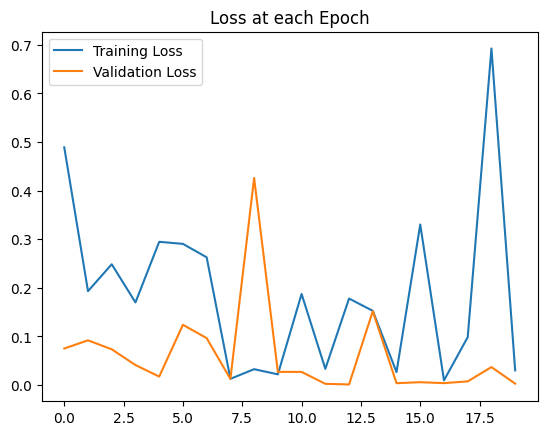

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

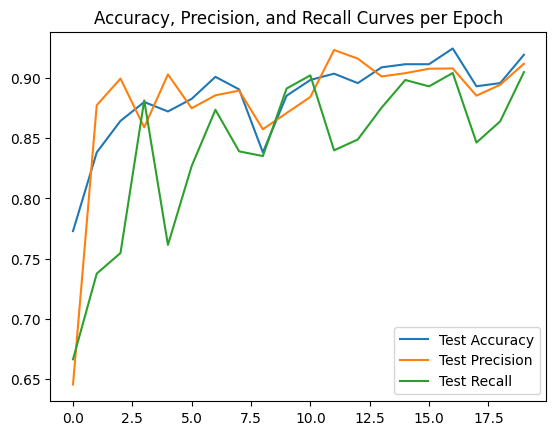

In [11]:
plt.plot(accuracy_graph, label="Test Accuracy")
plt.plot(precision_graph, label="Test Precision")
plt.plot(recall_graph, label="Test Recall")
plt.title('Accuracy, Precision, and Recall Curves per Epoch')
plt.legend()



['airport', 'golf_course', 'shipyard', 'stadium', 'wind_farm']
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4,
        1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 3

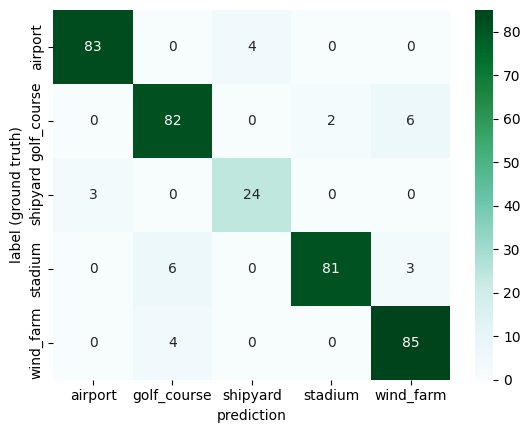

In [12]:
confusion_names = labels.copy()
print(confusion_names)
print(predicted)
arr = confusion_matrix(y_test.cpu().view(-1), predicted.cpu().view(-1))
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [13]:
pred = labels.index('Textile Trash')
lbl = labels.index('Paper')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))



ValueError: 'Textile Trash' is not in list

Index: [  420   421   423   424   425   426   428   429   431   432   433   434
   435   436   437   439   441   442   443   444   446]
Label: [    7     7     7     7     7     7     7     7     7     7     7     7
     7     7     7     7     7     7     7     7     7]
Class:  Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash

Guess: [    7     7     7     7     7     7     7     7     7     7     7     7
     7     7     7     7     7     7     7     7     7]
Class:  Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash Textile Trash T

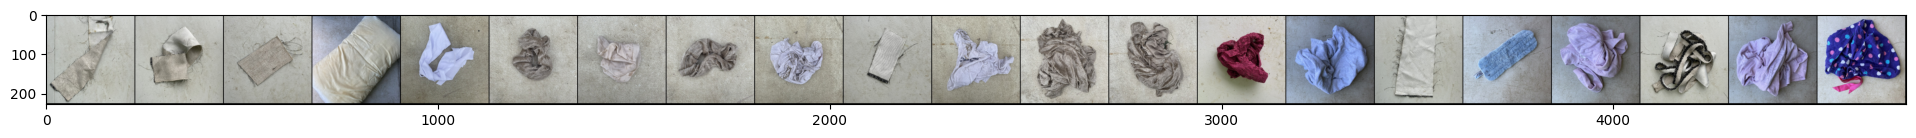

In [ ]:
pred = labels.index('Textile Trash')
lbl = labels.index('Textile Trash')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))